In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-04 00:32:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.119.8, 52.217.204.160, 52.217.135.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.119.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  15.0MB/s    in 0.9s    

2024-04-04 00:32:56 (15.0 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries

Text(0, 0.5, 'Temperature')

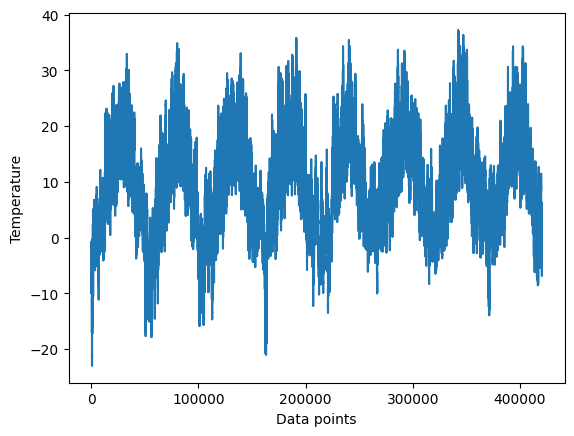

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


*Preparing the data*

Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline

Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Predicting that the temperature in the next 24 hours will be the same as the current temperature is a common-sense baseline approach. The test MAE is 2.62 degrees Celsius, whereas the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius using the straightforward baseline. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

In [1]:
!pip install tensorflow==2.12

A basic machine-learning model - Dense Layer

Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [15]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 38s 46ms/step - loss: 15.2715 - mae: 3.0061 - val_loss: 12.9050 - val_mae: 2.8165
Epoch 2/10
819/819 [==============================] - 38s 47ms/step - loss: 9.5550 - mae: 2.4359 - val_loss: 10.7536 - val_mae: 2.5727
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.5148 - mae: 2.3037 - val_loss: 11.0407 - val_mae: 2.6138
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 7.9356 - mae: 2.2269 - val_loss: 10.7790 - val_mae: 2.5842
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.5903 - mae: 2.1794 - val_loss: 11.1567 - val_mae: 2.6345
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 7.3187 - mae: 2.1424 - val_loss: 13.1471 - val_mae: 2.8441
Epoch 7/10
819/819 [==============================] - 37s 45ms/step - loss: 7.0970 - mae: 2.1104 - val_loss: 11.5681 - val_mae: 2.6886
Epoch 8/10
819/819 [==============================] - 

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 12s 29ms/step - loss: 11.9140 - mae: 2.7134
Test MAE: 2.71


Plotting results

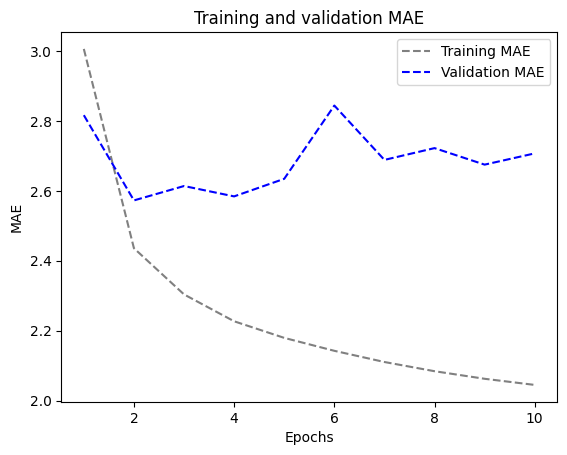

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 76s 92ms/step - loss: 22.8587 - mae: 3.7567 - val_loss: 16.7192 - val_mae: 3.2229
Epoch 2/10
819/819 [==============================] - 73s 89ms/step - loss: 15.4569 - mae: 3.1289 - val_loss: 16.9359 - val_mae: 3.2728
Epoch 3/10
819/819 [==============================] - 76s 92ms/step - loss: 14.1237 - mae: 2.9819 - val_loss: 15.9491 - val_mae: 3.1388
Epoch 4/10
819/819 [==============================] - 73s 89ms/step - loss: 13.1540 - mae: 2.8726 - val_loss: 19.1237 - val_mae: 3.3902
Epoch 5/10
819/819 [==============================] - 72s 88ms/step - loss: 12.4429 - mae: 2.7939 - val_loss: 16.7658 - val_mae: 3.2385
Epoch 6/10
819/819 [==============================] - 74s 90ms/step - loss: 11.9167 - mae: 2.7354 - val_loss: 16.0642 - val_mae: 3.1336
Epoch 7/10
819/819 [==============================] - 80s 97ms/step - loss: 11.4886 - mae: 2.6837 - val_loss: 21.4474 - val_mae: 3.7022
Epoch 8/10
819/819 [============================

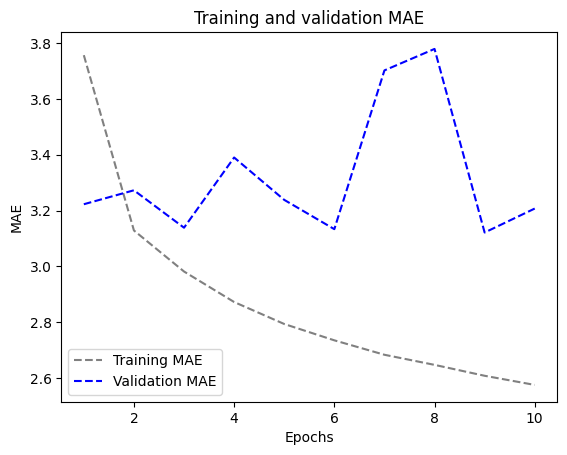

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems that the convolutional data performed poor compared to common sense or dense model. This could be because
- The assumption of translation invariance does not hold well for weather data.
- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.

A Simple RNN

1.An RNN layer that can process sequences of any length

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 63s 76ms/step - loss: 139.3988 - mae: 9.7302 - val_loss: 144.5480 - val_mae: 9.9575
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 136.5366 - mae: 9.5735 - val_loss: 143.7383 - val_mae: 9.8702
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 136.2871 - mae: 9.5493 - val_loss: 143.6257 - val_mae: 9.8562
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 136.2029 - mae: 9.5411 - val_loss: 143.5725 - val_mae: 9.8509
Epoch 5/10
819/819 [==============================] - 61s 74ms/step - loss: 136.1668 - mae: 9.5380 - val_loss: 143.5470 - val_mae: 9.8487
Epoch 6/10
819/819 [==============================] - 60s 72ms/step - loss: 136.1438 - mae: 9.5374 - val_loss: 143.5433 - val_mae: 9.8488
Epoch 7/10
819/819 [==============================] - 60s 74ms/step - loss: 136.1371 - mae: 9.5348 - val_loss: 143.5641 - val_mae: 9.8532
Epoch 8/10
819/819 [==============

2.Simple RNN - Stacking RNN layers

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 116s 138ms/step - loss: 137.0779 - mae: 9.5793 - val_loss: 143.4845 - val_mae: 9.8441
Epoch 2/10
819/819 [==============================] - 112s 136ms/step - loss: 135.9530 - mae: 9.5132 - val_loss: 143.4158 - val_mae: 9.8349
Epoch 3/10
819/819 [==============================] - 112s 136ms/step - loss: 135.8967 - mae: 9.5048 - val_loss: 143.3610 - val_mae: 9.8301
Epoch 4/10
819/819 [==============================] - 111s 135ms/step - loss: 135.8647 - mae: 9.5006 - val_loss: 143.3772 - val_mae: 9.8307
Epoch 5/10
819/819 [==============================] - 110s 134ms/step - loss: 135.8464 - mae: 9.4974 - val_loss: 143.4470 - val_mae: 9.8446
Epoch 6/10
819/819 [==============================] - 109s 132ms/step - loss: 135.8242 - mae: 9.4946 - val_loss: 143.4555 - val_mae: 9.8448
Epoch 7/10
819/819 [==============================] - 112s 137ms/step - loss: 135.8088 - mae: 9.4928 - val_loss: 143.5843 - val_mae: 9.8561
Epoch 8/10
819/819 [

A Simple GRU (Gated Recurrent Unit)

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 117ms/step - loss: 41.9658 - mae: 4.7077 - val_loss: 12.6767 - val_mae: 2.6782
Epoch 2/10
819/819 [==============================] - 93s 114ms/step - loss: 10.8459 - mae: 2.5652 - val_loss: 10.3776 - val_mae: 2.4591
Epoch 3/10
819/819 [==============================] - 96s 116ms/step - loss: 9.7205 - mae: 2.4401 - val_loss: 9.4729 - val_mae: 2.3761
Epoch 4/10
819/819 [==============================] - 95s 116ms/step - loss: 9.2751 - mae: 2.3821 - val_loss: 9.7597 - val_mae: 2.3948
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 9.0326 - mae: 2.3503 - val_loss: 10.0187 - val_mae: 2.4094
Epoch 6/10
819/819 [==============================] - 93s 113ms/step - loss: 8.8346 - mae: 2.3247 - val_loss: 9.6363 - val_mae: 2.3802
Epoch 7/10
819/819 [==============================] - 97s 118ms/step - loss: 8.6604 - mae: 2.3042 - val_loss: 9.7145 - val_mae: 2.4022
Epoch 8/10
819/819 [==============================

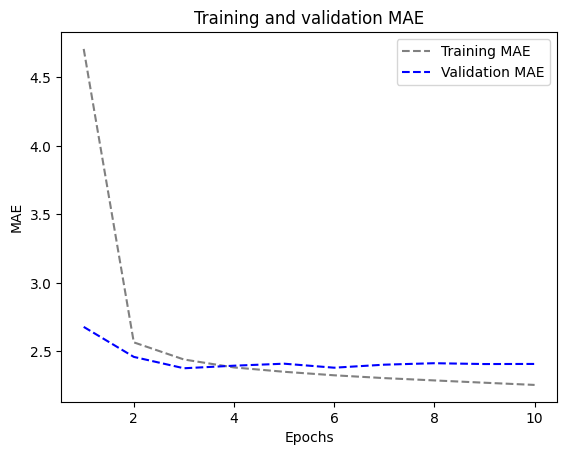

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 95s 113ms/step - loss: 39.4396 - mae: 4.5601 - val_loss: 12.0195 - val_mae: 2.6575
Epoch 2/10
819/819 [==============================] - 93s 113ms/step - loss: 10.9264 - mae: 2.5619 - val_loss: 9.6890 - val_mae: 2.4338
Epoch 3/10
819/819 [==============================] - 94s 114ms/step - loss: 9.8982 - mae: 2.4493 - val_loss: 9.6878 - val_mae: 2.4297
Epoch 4/10
819/819 [==============================] - 92s 113ms/step - loss: 9.5260 - mae: 2.4042 - val_loss: 9.6592 - val_mae: 2.4166
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 9.2667 - mae: 2.3698 - val_loss: 9.3334 - val_mae: 2.3732
Epoch 6/10
819/819 [==============================] - 93s 113ms/step - loss: 9.0583 - mae: 2.3415 - val_loss: 9.4134 - val_mae: 2.3842
Epoch 7/10
819/819 [==============================] - 94s 114ms/step - loss: 8.8326 - mae: 2.3084 - val_loss: 9.4207 - val_mae: 2.3838
Epoch 8/10
819/819 [==============================] 

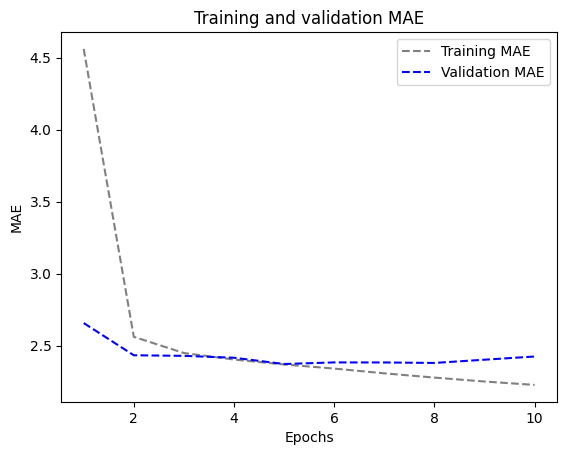

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 162s 195ms/step - loss: 45.5765 - mae: 5.0153 - val_loss: 12.6630 - val_mae: 2.6829
Epoch 2/10
819/819 [==============================] - 158s 193ms/step - loss: 19.6835 - mae: 3.4070 - val_loss: 9.9844 - val_mae: 2.4475
Epoch 3/10
819/819 [==============================] - 155s 189ms/step - loss: 18.2486 - mae: 3.2816 - val_loss: 9.6915 - val_mae: 2.4201
Epoch 4/10
819/819 [==============================] - 158s 192ms/step - loss: 17.5097 - mae: 3.2176 - val_loss: 9.3279 - val_mae: 2.3732
Epoch 5/10
819/819 [==============================] - 158s 192ms/step - loss: 16.7761 - mae: 3.1473 - val_loss: 9.4079 - val_mae: 2.3799
Epoch 6/10
819/819 [==============================] - 155s 189ms/step - loss: 16.3711 - mae: 3.1121 - val_loss: 9.3432 - val_mae: 2.3778
Epoch 7/10
819/819 [==============================] - 157s 192ms/step - loss: 15.9154 - mae: 3.0729 - val_loss: 9.3409 - val_mae: 2.3751
Epoch 8/10
819/819 [====================

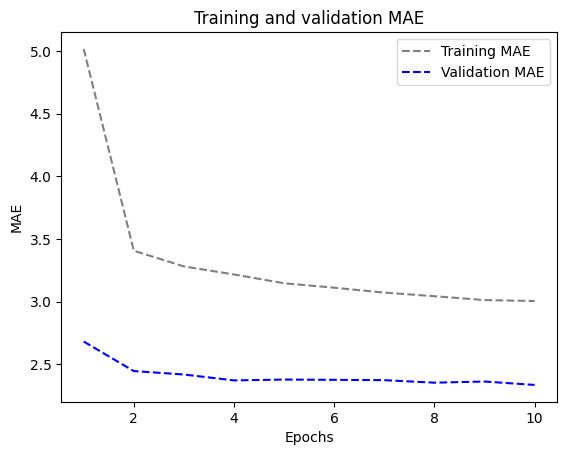

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - dropout-regularized, stacked model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 246s 295ms/step - loss: 76.6714 - mae: 6.7606 - val_loss: 38.2394 - val_mae: 4.6184
Epoch 2/10
819/819 [==============================] - 240s 293ms/step - loss: 33.0674 - mae: 4.2938 - val_loss: 14.4596 - val_mae: 2.8241
Epoch 3/10
819/819 [==============================] - 241s 293ms/step - loss: 24.6440 - mae: 3.7510 - val_loss: 10.9697 - val_mae: 2.5143
Epoch 4/10
819/819 [==============================] - 254s 310ms/step - loss: 22.4828 - mae: 3.5999 - val_loss: 10.1459 - val_mae: 2.4394
Epoch 5/10
819/819 [==============================] - 244s 298ms/step - loss: 21.3799 - mae: 3.5091 - val_loss: 10.0162 - val_mae: 2.4366
Epoch 6/10
819/819 [==============================] - 243s 297ms/step - loss: 20.2618 - mae: 3.4249 - val_loss: 9.8516 - val_mae: 2.4244
Epoch 7/10
819/819 [==============================] - 242s 295ms/step - loss: 19.5670 - mae: 3.3627 - val_loss: 9.6916 - val_mae: 2.4051
Epoch 8/10
819/819 [================

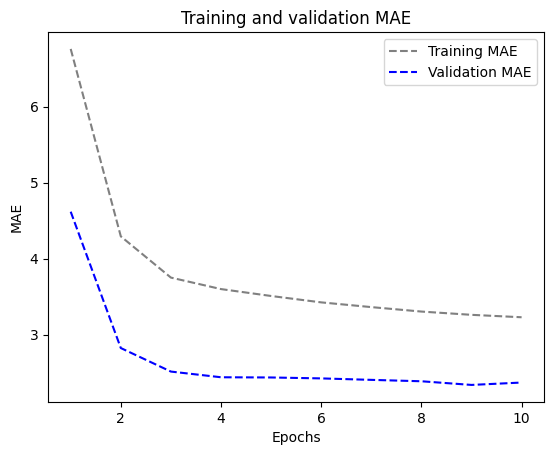

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 140s 166ms/step - loss: 25.9805 - mae: 3.6801 - val_loss: 10.8706 - val_mae: 2.5545
Epoch 2/10
819/819 [==============================] - 138s 168ms/step - loss: 9.6921 - mae: 2.4298 - val_loss: 9.6898 - val_mae: 2.4136
Epoch 3/10
819/819 [==============================] - 137s 167ms/step - loss: 8.8407 - mae: 2.3132 - val_loss: 9.8810 - val_mae: 2.4505
Epoch 4/10
819/819 [==============================] - 137s 167ms/step - loss: 8.4065 - mae: 2.2505 - val_loss: 9.6437 - val_mae: 2.4104
Epoch 5/10
819/819 [==============================] - 139s 169ms/step - loss: 8.0614 - mae: 2.2046 - val_loss: 10.1870 - val_mae: 2.4714
Epoch 6/10
819/819 [==============================] - 136s 166ms/step - loss: 7.7471 - mae: 2.1641 - val_loss: 10.8471 - val_mae: 2.5451
Epoch 7/10
819/819 [==============================] - 137s 167ms/step - loss: 7.4842 - mae: 2.1270 - val_loss: 11.1078 - val_mae: 2.5510
Epoch 8/10
819/819 [=======================

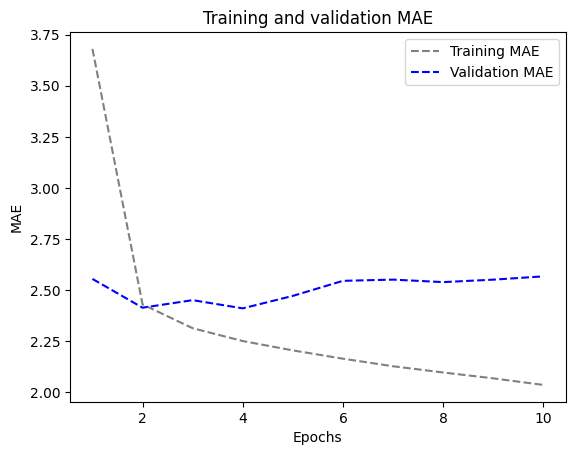

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togthe

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 116ms/step - loss: 51.7973 - mae: 5.3999 - val_loss: 26.0178 - val_mae: 3.9266
Epoch 2/10
819/819 [==============================] - 92s 112ms/step - loss: 18.0265 - mae: 3.2780 - val_loss: 20.7812 - val_mae: 3.6082
Epoch 3/10
819/819 [==============================] - 93s 114ms/step - loss: 14.7173 - mae: 2.9798 - val_loss: 22.8089 - val_mae: 3.7587
Epoch 4/10
819/819 [==============================] - 93s 114ms/step - loss: 13.0292 - mae: 2.7991 - val_loss: 22.3832 - val_mae: 3.7532
Epoch 5/10
819/819 [==============================] - 92s 113ms/step - loss: 11.9026 - mae: 2.6699 - val_loss: 24.1479 - val_mae: 3.8840
Epoch 6/10
819/819 [==============================] - 91s 111ms/step - loss: 11.0358 - mae: 2.5651 - val_loss: 23.4699 - val_mae: 3.8417
Epoch 7/10
819/819 [==============================] - 92s 112ms/step - loss: 10.2939 - mae: 2.4712 - val_loss: 25.3349 - val_mae: 4.0618
Epoch 8/10
819/819 [=====================

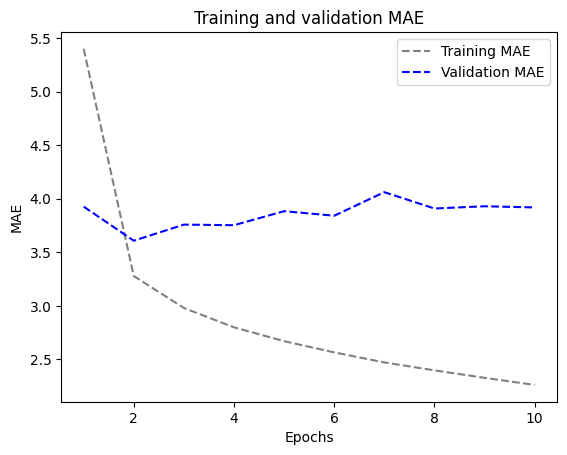

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

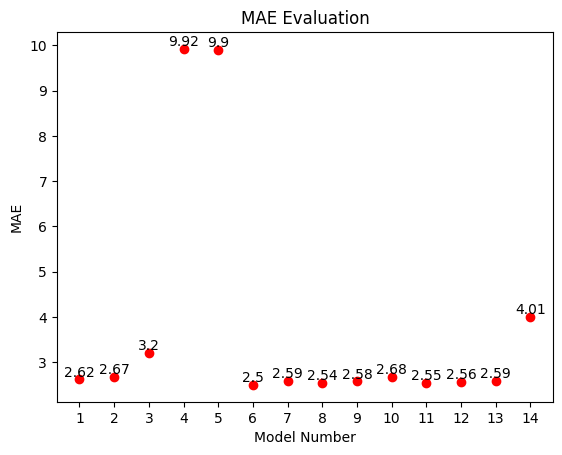

In [35]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()